# Summary

I can use PyMC3 to estimate the posterior PDF for the true skill level of every BUDA team using its W-L record during the season. This could be superior to my initial approach of assuming a discrete skill level based on Division and then modifying that skill level based on individual game outcomes. It will also serve as a great playground in which to explore PyMC3. 

Now that I've tested that things out with a small sample of artificial game data, it's time to run this on BUDA summer club league data.

In [2]:
import pandas as pd
import os
import numpy as np
import pymc3 as pm
from pymc3.math import invlogit
from tqdm import tqdm
from theano import tensor as tt

%matplotlib inline

In [2]:
project_dir = '/Users/rbussman/Projects/BUDA/buda-ratings'
scores_dir = os.path.join(project_dir, 'data', 'raw', 'game_scores')

In [3]:
# summer club league 2016
league_id = 40264
game_scores = pd.read_csv(os.path.join(scores_dir, 'scores_{}.csv'.format(league_id)))

In [4]:
game_scores.head()

,Team A,Team B,Tourney Qualifying games*,divname,Score A,Score B
0,AHOC,Gothrilla,-99,4/3 Div 1,15,12
1,AHOC,BBN,-99,4/3 Div 1,15,1
2,AHOC,Stonecutters,-99,4/3 Div 1,15,8
3,AHOC,FlowChart,-99,4/3 Div 1,15,10
4,AHOC,Lady and the BAMF,-99,4/3 Div 1,15,5


In [6]:
game_scores['Team A Wins'] = game_scores['Score A'] > game_scores['Score B']

In [7]:
game_scores.tail()

,Team A,Team B,Tourney Qualifying games*,divname,Score A,Score B,Team A Wins
1161,Sky Zone,Stall 9,-99,Open Div 2,10,15,False
1162,Sky Zone,Hammered,-99,Open Div 2,13,15,False
1163,Sky Zone,Squid Squad,-99,Open Div 2,7,15,False
1164,Sky Zone,Crossroads,-99,Open Div 2,5,15,False
1165,Sky Zone,Rabbit Disc,-99,Open Div 2,13,15,False


In [8]:
teams = game_scores['Team A'].unique()

In [9]:
n_teams = len(teams)

In [10]:
game_scores.head()

,Team A,Team B,Tourney Qualifying games*,divname,Score A,Score B,Team A Wins
0,AHOC,Gothrilla,-99,4/3 Div 1,15,12,True
1,AHOC,BBN,-99,4/3 Div 1,15,1,True
2,AHOC,Stonecutters,-99,4/3 Div 1,15,8,True
3,AHOC,FlowChart,-99,4/3 Div 1,15,10,True
4,AHOC,Lady and the BAMF,-99,4/3 Div 1,15,5,True


In [11]:
team2index = {}
team2div = {}
for i, team in enumerate(teams):
    row = game_scores['Team A'] == team
    div_team = game_scores.loc[row, 'divname'].unique()[0]
    team2div[team] = div_team
    team2index[team] = i

In [12]:
game_scores['Index A'] = game_scores['Team A'].apply(lambda x: team2index[x])
game_scores['Index B'] = game_scores['Team B'].apply(lambda x: team2index[x])
game_scores['Div A'] = game_scores['Team A'].apply(lambda x: team2div[x])
game_scores['Div B'] = game_scores['Team B'].apply(lambda x: team2div[x])


In [13]:
sub_scores = game_scores.copy()
for div in ['Open Div 1', 'Open Div 2']:
    sub1 = (sub_scores['Div A'] == div) | (sub_scores['Div B'] == div)
    sub_scores = sub_scores[~sub1]

In [14]:
sub_scores.tail()

,Team A,Team B,Tourney Qualifying games*,divname,Score A,Score B,Team A Wins,Index A,Index B,Div A,Div B
1044,Spawning Alewives,Rabbit Disc,-99,5/2 Div 3,7,15,False,66,54,5/2 Div 3,5/2 Div 3
1045,Spawning Alewives,Flying Salsa,-99,5/2 Div 3,8,15,False,66,56,5/2 Div 3,5/2 Div 3
1046,Spawning Alewives,Granite State Grass Stains,-99,5/2 Div 3,1,0,True,66,55,5/2 Div 3,5/2 Div 3
1047,Spawning Alewives,M.O.B.,-99,5/2 Div 3,12,15,False,66,65,5/2 Div 3,5/2 Div 3
1048,Spawning Alewives,Batman and the Robins,-99,5/2 Div 3,7,15,False,66,34,5/2 Div 3,4/3 Div 3


In [15]:
n_teams = len(sub_scores['Team A'].unique())

In [16]:
n_teams

67

In [17]:
len(sub_scores)

1044

Prior on each team is a normal distribution with mean of 1600 and standard deviation of 200.

> First attempt with 78 teams and 1166 game scores leads to a compilation error: "fatal error: bracket nesting level exceeded maximum of 256". I will try to get around this by filtering out the Open teams and de-duplicating the game scores database. Currently every game score is present twice.

Removing Open teams and de-duplicating gets me down to 67 teams and 527 scores. With this many teams and scores, I still have compilation errors or computer restart issues. Trimming down to top 30 teams is manageable, however. For now, stick with top 30 teams. Will plan to come back later on to explore optimization options.

The most pressing issue now is that Div2 teams get similar scores to Div1 teams. I need to use a different prior on skill for each division. Roughly speaking, I expect that:
 - an average div1 team will beat an average div2 team 95% of the time
 - an average div2 team will beat an average div3 team 90% of the time
 - an average div3 team will beat an average div4 team 75% of the time
 
Posted on pymc3 discourse page and got a helpful response from @aseyboldt. Turns out I can just index `skill` with an array of integers and get the speed boost that I need.

In [18]:
pair_list = []
for row in tqdm(sub_scores.index):
    team_A = sub_scores.loc[row, 'Index A']
    team_B = sub_scores.loc[row, 'Index B']
    new_pair = (team_A, team_B)
    pair_list.append(new_pair)
    reverse_pair = (team_B, team_A)
    if reverse_pair in pair_list:
        sub_scores = sub_scores.drop(row)


100%|██████████| 1044/1044 [00:00<00:00, 2243.30it/s]


In [19]:
len(sub_scores)

522

In [20]:
sub_scores = sub_scores.reset_index().drop('index', axis=1)

In [21]:
sub_scores.tail()

,Team A,Team B,Tourney Qualifying games*,divname,Score A,Score B,Team A Wins,Index A,Index B,Div A,Div B
517,THEM!,Spawning Alewives,-99,5/2 Div 3,12,9,True,62,66,5/2 Div 3,5/2 Div 3
518,THEM!,SIR!,-99,5/2 Div 3,12,15,False,62,64,5/2 Div 3,5/2 Div 3
519,THEM!,Jiggy,-99,5/2 Div 3,0,1,False,62,63,5/2 Div 3,5/2 Div 3
520,SIR!,M.O.B.,-99,5/2 Div 3,15,12,True,64,65,5/2 Div 3,5/2 Div 3
521,M.O.B.,Spawning Alewives,-99,5/2 Div 3,15,12,True,65,66,5/2 Div 3,5/2 Div 3


In [22]:
n_teams

67

In [23]:
sub_scores

,Team A,Team B,Tourney Qualifying games*,divname,Score A,Score B,Team A Wins,Index A,Index B,Div A,Div B
0,AHOC,Gothrilla,-99,4/3 Div 1,15,12,True,0,1,4/3 Div 1,4/3 Div 1
1,AHOC,BBN,-99,4/3 Div 1,15,1,True,0,9,4/3 Div 1,4/3 Div 1
2,AHOC,Stonecutters,-99,4/3 Div 1,15,8,True,0,41,4/3 Div 1,5/2 Div 1
3,AHOC,FlowChart,-99,4/3 Div 1,15,10,True,0,2,4/3 Div 1,4/3 Div 1
4,AHOC,Lady and the BAMF,-99,4/3 Div 1,15,5,True,0,28,4/3 Div 1,4/3 Div 2
5,AHOC,Swingers,-99,4/3 Div 1,15,11,True,0,5,4/3 Div 1,4/3 Div 1
6,AHOC,Upstream,-99,4/3 Div 1,15,10,True,0,10,4/3 Div 1,4/3 Div 2
7,AHOC,Tubbs,-99,4/3 Div 1,15,6,True,0,29,4/3 Div 1,4/3 Div 2
8,AHOC,Stonecutters,-99,4/3 Div 1,15,10,True,0,41,4/3 Div 1,5/2 Div 1
9,AHOC,Zerg Rush!,-99,4/3 Div 1,15,8,True,0,4,4/3 Div 1,4/3 Div 1


In [24]:
teams = set(np.append(sub_scores['Team A'].unique(), sub_scores['Team B'].unique()))

In [25]:
len(teams)

67

In [80]:
skill_prior_div = {
    '4/3 Div 1': 3.0,
    '4/3 Div 2': 0.0,
    '4/3 Div 3': -1.0,
    '5/2 Div 1': 3.0,
    '5/2 Div 2': 0.0,
    '5/2 Div 3': -1.0
}
alphas = []
for i in range(len(teams)):
    if i in sub_scores['Index A'].values:
        index = sub_scores['Index A'] == i
        div = sub_scores.loc[index, 'Div A'].unique()[0]
        alpha = skill_prior_div[div]
        alphas.append(alpha)
    else:
        index = sub_scores['Index B'] == i
        div = sub_scores.loc[index, 'Div B'].unique()[0]
        alpha = skill_prior_div[div]
        alphas.append(alpha)
        
#     div = sub_scores[team]
#     alpha = skill_prior_div[div]
#     print(team, alpha)
#     alphas.append(alpha)

In [82]:
team1 = sub_scores['Index A'].values
team2 = sub_scores['Index B'].values

with pm.Model() as model:
    skill_sd = pm.HalfStudentT('skill_sd', sd=2.5, nu=3)
    skill = pm.Normal('skill', mu=alphas, shape=len(teams))
    
    logit_p = skill_sd * (skill[team1] - skill[team2])
#     logit_p = skill[team1] - skill[team2]

#     lower = 1e-6
#     upper = 1 - 1e-6
#     B_minus_A = skill[team2] - skill[team1]
#     probability_A_beats_B = lower + (upper - lower) * 1 / (1 + tt.exp(B_minus_A))

    p = tt.nnet.sigmoid(logit_p)
    win = pm.Bernoulli('win', p, observed=sub_scores['Team A Wins'].values)

In [83]:
with model:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 299.01:   6%|▌         | 11203/200000 [00:01<00:28, 6718.45it/s]
Convergence archived at 11600
Interrupted at 11,600 [5%]: Average Loss = 328.5
100%|██████████| 1500/1500 [00:03<00:00, 482.61it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1246dbdd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x125927610>]], dtype=object)

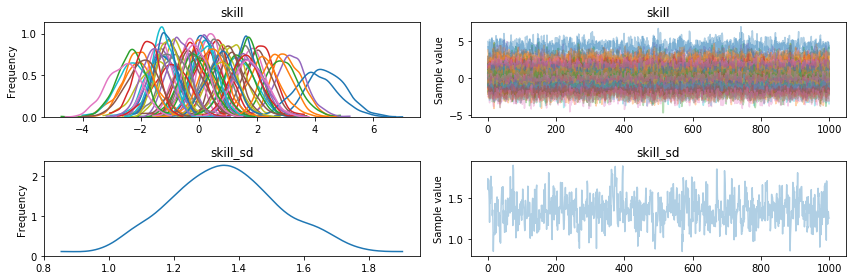

In [84]:
pm.traceplot(trace)

In [85]:
trace.varnames

['skill_sd_lowerbound__', 'skill', 'skill_sd']

In [86]:
meanskills = trace.get_values('skill').mean(axis=0)

In [87]:
for i, meanskill in enumerate(meanskills):
    if i in sub_scores['Index A'].values:
        index = sub_scores['Index A'] == i
        name = sub_scores.loc[index, 'Team A'].unique()[0]
    else:
        index = sub_scores['Index B'] == i
        name = sub_scores.loc[index, 'Team B'].unique()[0]
    print("{}: {:.3f}".format(name, meanskill))

AHOC: 4.419
Gothrilla: 3.046
FlowChart: 2.883
GrassBurner: 2.173
Zerg Rush!: 3.179
Swingers: 1.995
TuneSquad: 1.827
Turtle Boy: 1.583
Live Poultry, Fresh Killed (LPFK): 1.180
BBN: 1.404
Upstream: 1.641
Injustice League: 2.241
Puddingstone: 1.731
Flaming Croissants: 0.683
Jack's Abby HAOS Lager: 1.678
License to Kilt (fka Scoobers in Scotland): 0.984
Toads: 0.392
JHOP: 0.581
Rubs The Duckie: 0.813
Disc Envy: 0.191
Store Bought Dirt: 0.121
Fetch: 0.004
Booooooosh!: 0.045
Dominion: 0.305
Rogues' Gallery: 0.240
A Lil Bit Sticky: -0.156
Nerd Alert: -0.399
Moose Lightning: -0.099
Lady and the BAMF: -0.818
Tubbs: -1.324
Hipster Kitties: -1.232
TuneSquad Squared: -2.088
Too Drunk to Fail: 0.194
Oddjob: -0.302
Batman and the Robins: -1.266
Stack to the Future: -1.081
Underwater Monkey Cowboys: -1.357
Baboon Heart: -1.026
Top Shelf: -1.517
123 Trap!: -2.221
SnakeCountryBromance: 4.011
Stonecutters: 2.693
Shake and Bake: 1.366
JuJu Hex: 1.593
Pink Flamingos: 1.724
Baba Yaga: 1.184
Maverick: 1.743

In [73]:
i in sub_scores['Index A'].values

False

In [69]:
index = sub_scores['Index A'] == i

In [71]:
name = sub_scores.loc[index, 'Team A'].unique()

In [72]:
name

array([], dtype=object)

In [172]:
i in sub_scores['Index A']

True

In [175]:
sub_scores['Index B'].unique()

array([ 1,  9, 11,  2, 18,  5, 19,  4,  7,  8,  6, 22, 29, 10,  3, 12, 13,
       14, 17, 20, 30, 21, 15, 16, 31, 25, 23, 24, 28, 27, 32, 26])

In [60]:
with pm.Model() as model:
    skill = pm.Cauchy('skill', alpha=alphas, beta=0.5, shape=len(teams))
#     skill_div3 = pm.Cauchy('skill_div3', alpha=-1.0, beta=0.5, shape=n_teams3)
#     skill_div4 = pm.Cauchy('skill_div4', alpha=-3.0, beta=0.5, shape=n_teams4)
#     skill = pm.Lognormal('skill', mu=0, tau=1, shape=n_teams + 2)
#     skill = pm.Exponential('skill', lam=1, shape=n_teams + 2)

#     scale = pm.HalfNormal('scale', sd=100)

    A_minus_B = []
    B_minus_A = []
    for row in mixed_scores.index:
        team_A = mixed_scores.loc[row, 'ID A']
        team_B = mixed_scores.loc[row, 'ID B']
        div_A = mixed_scores.loc[row, 'divname']
#         print(team_A, team_B)
        A_minus_B.append(skill[team_A] - skill[team_B])
        B_minus_A.append(skill[team_B] - skill[team_A])
#     A_minus_B = np.array(A_minus_B)
    lower = 1e-6
    upper = 1 - 1e-6
    probability_A_beats_B = lower + (upper - lower) * 1 / (1 + tt.exp(B_minus_A))
    
#     probability_A_beats_B = pm.math.invlogit(A_minus_B)
#     probability_A_beats_B = 1. / (1 + pm.math.exp(B_minus_A))
    
    observation = pm.Bernoulli('observation', probability_A_beats_B, observed=mixed_scores['Team A Wins'].values)
    
    

In [38]:
with pm.Model() as model:
#     skill = pm.Cauchy('skill', alpha=alphas, beta=0.5, shape=len(teams))
    skill = pm.Normal('skill', sd=0.5, shape=len(teams))

    B_minus_A = skill[sub_scores['Index B'].values] - skill[sub_scores['Index A'].values]

    lower = 1e-6
    upper = 1 - 1e-6
    probability_A_beats_B = lower + (upper - lower) * 1 / (1 + tt.exp(B_minus_A))
    
#     probability_A_beats_B = pm.math.invlogit(A_minus_B)
#     probability_A_beats_B = 1. / (1 + pm.math.exp(B_minus_A))
    
    observation = pm.Bernoulli('observation', probability_A_beats_B, observed=sub_scores['Team A Wins'].values)
    
    

In [52]:
i

13

In [7]:
xplot = np.arange(-15, 15, 0.1)

In [8]:
yplot = 1 / (1 + np.exp(-xplot))

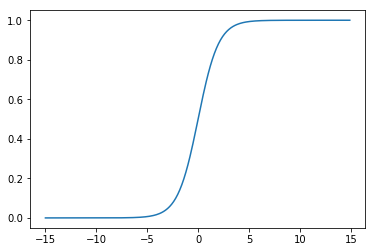

In [9]:
import matplotlib.pyplot as plt
plt.plot(xplot, yplot)
